## Fine-tuning de diferentes encocders para Multiple Choice QA 

En el siguiente notebook se presentan los resultados obtenidos al fine-tunear diferentes encoders para la tarea de Multiple Choice QA en español, utilizando el dataset HeadQA_ES.

El procedimiento general que se ha seguido es el siguiente:
1. **Carga del dataset**: Se carga el dataset HeadQA_ES y se divide en conjuntos de entrenamiento, validación y prueba. Estos mismos conjuntos se utilizan en todos los demás experimentos del proyecto para asegurar la comparabilidad de los resultados.
2. **Preprocesamiento**: Se preprocesan las preguntas y respuestas del dataset. Específicamente, para modelos como BERT, se crean 5 pares (pues hay 5 opciones de respuesta) de pregunta-respuesta. 
3. **Fine-tuning de los encoders**: Se obtiene del token [CLS] para cada par pregunta-respuesta y se utilizan dos capas densas de clasificación para predecir la respuesta correcta.
4. **Evaluación**: Se evalúa el rendimiento de los modelos fine-tuneados en el conjunto de prueba utilizando métricas como accuracy, precision, recall y F1-score.

Se obtienen resultados variando modelos y número de capas descongeladas (niguna, las últimas 2 capas o todas las capas).

In [1]:
!pip install pandas torch seaborn protobuf --quiet

In [ ]:
import tqdm
import copy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/estudiante/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Confituracion del entorno:

In [2]:
RANDOM_SEED = 26
MAX_LEN_TOKENIZER = 312
BATCH_SIZE = 16

Lectura de datos

In [3]:
df = pd.read_csv('data/head_qa_dataset.csv', index_col = 0)
df.head()

,qid,qtext,ra,image,answer_1,answer_2,answer_3,answer_4,answer_5
0,1,Forma fibras extracelulares con gran resistenc...,2,NaN,Fibronectina.,Colágeno.,Integrinas.,Proteoglucanos.,Respuesta incorrecta
1,2,El fosfolípido cardiolipina es abundante en la...,1,NaN,Mitocondrial interna.,Mitocondrial externa.,Plasmática.,Lisosomal.,Respuesta incorrecta
2,3,NO es una función de los filamentos intermedios:,4,NaN,Proporcionar apoyo estructural a la célula.,Fijar el núcleo en su sitio.,Proveer resistencia mecánica.,Locomoción celular.,Respuesta incorrecta
3,4,Los cuerpos multivesiculares son:,4,NaN,Peroxisomas.,Mitocondrias.,Polisomas.,Endosomas.,Respuesta incorrecta
4,5,Forman la envuelta de mielina de los axones en...,2,NaN,Oligodendrocitos.,Células de Schwann.,Células microgliales.,Células ganglionares.,Respuesta incorrecta


Definición de modelos a usar:
Se usan tres modelos preentrenados en español:
- bert-base-spanish-wwm-cased: Modelo BERT preentrenado en español.
- electricidad-base-discriminator: Modelo en base en Electra preentrenado en español cuyo entrenamiento original consiste en distinguir tokens reales de tokens falsos. Este tipo de modelos son efectivos en tareas de clasificación, así que, a pesar de que la tarea que se tiene no es completamente de clasificación, resulta interesante probar su rendimiento.
- SapBERT-from-roberta-base-biomedical-clinical-es: Modelo basado en RoBERTa preentrenado en textos biomédicos y clínicos en español. Las ventajas de usar este modelo está en que contiene embeddings más especializados en el dominio de la salud.


In [4]:
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
MODEL_NAME2 = "mrm8488/electricidad-base-discriminator"
MODEL_NAME3 = "BSC-NLP4BIA/SapBERT-from-roberta-base-biomedical-clinical-es"

Separamos los datos en conjuntos train, test y val en proporciones 70%, 15% y 15% respectivamente. 

In [5]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED)

Realizamos primero una prueba del procesamiento de los datos. Cada respuesta debe ser procesada como [CLS] Qi [SEP] Ai [SEP][PAD]...

In [6]:
# Procesamiento de los datos
example = train_df.iloc[0]
text = example['qtext']
options = [example[f"answer_{i}"] for i in range(1, 6)]
print(f'pregunta: {text}')
print(f'respuestas: {options}')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoded = tokenizer(
    [text]*5,
    options,
    padding='max_length',
    max_length=MAX_LEN_TOKENIZER,
    truncation=True,
    return_tensors='pt',
    return_token_type_ids=True
)

# comprobar que esta bien hecho
for i, answer in enumerate(options):
    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][i])
    for i, tok in enumerate(tokens):
        if tok == '[PAD]': break
        print(f"{i:>3}: {tok}")

pregunta: Activa    el   sistema   renina-angiotensinaaldosterona un aumento de la:
respuestas: ['Presión arterial.', 'Actividad parasimpática.', 'Concentración de Ca2+ en plasma.', 'Concentración de Na+ en plasma.', 'Actividad simpática.']
  0: [CLS]
  1: Ac
  2: ##tiva
  3: el
  4: sistema
  5: ren
  6: ##ina
  7: -
  8: an
  9: ##gio
 10: ##tens
 11: ##ina
 12: ##aldo
 13: ##ster
 14: ##ona
 15: un
 16: aumento
 17: de
 18: la
 19: :
 20: [SEP]
 21: Pres
 22: ##ión
 23: arterial
 24: .
 25: [SEP]
  0: [CLS]
  1: Ac
  2: ##tiva
  3: el
  4: sistema
  5: ren
  6: ##ina
  7: -
  8: an
  9: ##gio
 10: ##tens
 11: ##ina
 12: ##aldo
 13: ##ster
 14: ##ona
 15: un
 16: aumento
 17: de
 18: la
 19: :
 20: [SEP]
 21: Actividad
 22: paras
 23: ##im
 24: ##pá
 25: ##tica
 26: .
 27: [SEP]
  0: [CLS]
  1: Ac
  2: ##tiva
  3: el
  4: sistema
  5: ren
  6: ##ina
  7: -
  8: an
  9: ##gio
 10: ##tens
 11: ##ina
 12: ##aldo
 13: ##ster
 14: ##ona
 15: un
 16: aumento
 17: de
 18: la
 19: :
 20: [SE

In [7]:
print(encoded['input_ids'].shape) # pasa cada par pregunta respuesta a una lista de 256 indices
# cada una ya tiene los tokens especiales CLS, SEP y PAD.


torch.Size([5, 312])


In [8]:
print(encoded['attention_mask'].shape) # igual con la mascara de atención

torch.Size([5, 312])


Definimos un dataset para uso con pytorch que retorne los indices del tokenizador (5 x MAX_LEN_TOKENIZER), la máscara de atención de igual tamaño y la respuesta correcta. Como nota adicional, se usó un tamño maximo de tokens de 256, pues gracias a la exploración previa de los datos es posible observar al rededor de esta longitud están las preguntas más largas del dataset, la gran mayoría siendo de menor longitud.

In [9]:
class MedicalQADataset(Dataset):
    def __init__(self, dataframe, model_name, max_len=256):
        self.dataframe = dataframe
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len

    def __len__(self): #numero de preguntas
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # tokenizar
        text = row['qtext']
        options = [row[f"answer_{i}"] for i in range(1, 6)]
        correct_answer = torch.tensor(row['ra']-1) # va de 1 a 5, lo quiero de 0 a 4

        tokenized_text = self.tokenizer(
            [text]*5,
            options,
            padding='max_length',
            max_length=256,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        return {
            'input_ids': tokenized_text['input_ids'], #(5 x max_len)
            'attention_mask': tokenized_text['attention_mask'], #(5 x max_len)
            'correct_answer': correct_answer
        }

A continuación se presenta una arquitectura para la tarea de clasificación de la respuesta correcta mediante fine-tuning de un encoder.
Dado que cada ejemplo cuenta con cinco opciones de respuesta, al procesarlas individualmente con BERT se obtienen cinco representaciones correspondientes al token [CLS].

Sobre estas representaciones se aplica una cabeza de clasificación cuya función es aprender a transformar el espacio de embeddings de manera que la opción correcta sea aquella cuyo [CLS] produzca la mayor probabilidad.

El modelo definido a continuación **congela todos los pesos del modelo**, entrenando entonces únicamente las capas densas para clasificación.

In [ ]:
class BertForMedicalQAFrozen(nn.Module):
    def __init__(self, model_name, hidden_dim=512, dropout=0.2):
        super().__init__()

        # cargar el encoder de bert para obtener representaciones
        self.bert = AutoModel.from_pretrained(model_name)

        # congelar los pesos 
        for param in self.bert.parameters():
            param.requires_grad = False

        # obtener la dimensión de los embeddings
        bert_dim = self.bert.config.hidden_size  
        print('Dimensión embeddings bert', bert_dim)

        # crear la cabeza de clasificación
        self.classifier = nn.Sequential(
            nn.Linear(bert_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)  # a la salida del clasificador se obtiene un logit por opción - hay que pasar los 5 de cada respuesta por una softmax
        )

    # Comentario: este forward está pensado para procesar una sola pregunta con sus 5 opciones de respuesta, el siguiente procesa un batch completo  
    # def forward(self, input_ids, attention_mask):
    #     num_choices, sequence_length = input_ids.shape
    #     logits_cls = []
    #     for i in range(num_choices):
    #         ids = input_ids[i]
    #         att_msk = attention_mask[i]
    #         output = self.bert(input_ids=ids, attention_mask=att_msk)

    #         cls_output = output.last_hidden_state[:, 0, :]  # representación del [CLS]

    #         logits = self.classifier(cls_output)
    #         logits_cls.append(logits)
        
    #     # logits deberia ser un tensor de tamaño 5 x 1
    #     logits_cls = torch.cat(logits_cls, dim=0)
    #     return logits_cls

    def forward(self, input_ids, attention_mask):
        """
        este forward está adaptado para un batch de tamaño batch_size
        input_ids: (batch_size, num_choices, seq_len)
        attention_mask: (batch_size, num_choices, seq_len)
        """
        bsz, num_choices, seq_len = input_ids.size()

        # aplastamos las dos primeras dimensiones
        # para pasar todo de una sola vez por BERT
        input_ids = input_ids.view(bsz * num_choices, seq_len) # tratamos todas las combinaciones pregunta-opción como secuencias independientes
        attention_mask = attention_mask.view(bsz * num_choices, seq_len)

        # pasamos por BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # (bsz*num_choices, hidden_size)

        # pasamos por la cabeza
        logits = self.classifier(cls_output)  # (bsz*num_choices, 1)

        # volvemos a separar por pregunta
        logits = logits.view(bsz, num_choices)  # (bsz, num_choices)

        return logits


Separamos los datasets de entrenamiento, validación y test con la clase de dataset definida previamente.

In [11]:
train_dataset = MedicalQADataset(train_df, MODEL_NAME, max_len=MAX_LEN_TOKENIZER)
val_dataset = MedicalQADataset(val_df, MODEL_NAME, max_len=MAX_LEN_TOKENIZER)
test_dataset = MedicalQADataset(test_df, MODEL_NAME, max_len=MAX_LEN_TOKENIZER)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Guardar los datasets
# train_df.to_csv('data/train.csv')
# val_df.to_csv('data/val.csv')
# test_df.to_csv('data/test.csv')

Definimos funciones para entrenamiento y evaluación del modelo.

In [ ]:
def train_model(MODEL_NAME:str, train_loader:torch.utils.data.DataLoader, val_loader:torch.utils.data.DataLoader, num_epochs=5, learning_rate=1e-3):
    """
    Función para entrenar el modelo de QA médica.
    Args:
    - MODEL_NAME (str): Nombre del modelo preentrenado.
    - train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
    - val_loader (DataLoader): DataLoader para el conjunto de validación.
    - num_epochs (int): Número de épocas para entrenar.
    - learning_rate (float): Tasa de aprendizaje para el optimizador.
    Returns:
    - model (nn.Module): Modelo entrenado."""
    model = BertForMedicalQAFrozen(MODEL_NAME, hidden_dim=512, dropout=0.2)
    print('Parametros entrenables:', sum(p.numel() for p in model.parameters() if p.requires_grad))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Mover tensores a gpu
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = batch['correct_answer'].to(device)

            # Forward
            optimizer.zero_grad() 
            logits = model(input_ids, attention_mask)

            # Calcular pérdida sobre los logits
            loss = criterion(logits, correct_answer)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Validación
        model.eval()
        val_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                correct_answer = batch['correct_answer'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, correct_answer)
                val_loss += loss.item()

                _, predicted = torch.max(logits, dim=1)
                preds.extend(predicted.cpu().numpy())
                labels.extend(correct_answer.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = np.mean(np.array(preds) == np.array(labels))
        f1 = f1_score(labels, preds, average='macro')

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Plot train loss y val loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [ ]:
def evaluate_model(model: nn.Module, test_dataloader: torch.utils.data.DataLoader):
    """
    Evalúa el modelo en el conjunto de datos de prueba y calcula métricas de rendimiento.
    Args:
    - model (nn.Module): Modelo entrenado.
    - test_dataloader (DataLoader): DataLoader para el conjunto de prueba.
    Returns:
    - None: Imprime las métricas de evaluación y muestra la matriz de confusión.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm.tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = batch['correct_answer'].to(device)

            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(correct_answer.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    metrics = {
        "Accuracy": np.mean(all_preds == all_labels),
        "F1 Macro": f1_score(all_labels, all_preds, average='macro'),
        "F1 Micro": f1_score(all_labels, all_preds, average='micro'),
        "F1 Weighted": f1_score(all_labels, all_preds, average='weighted'),

        "Precision Macro": precision_score(all_labels, all_preds, average='macro'),
        "Precision Micro": precision_score(all_labels, all_preds, average='micro'),
        "Precision Weighted": precision_score(all_labels, all_preds, average='weighted'),

        "Recall Macro": recall_score(all_labels, all_preds, average='macro'),
        "Recall Micro": recall_score(all_labels, all_preds, average='micro'),
        "Recall Weighted": recall_score(all_labels, all_preds, average='weighted'),
    }

    print("Resultados de la evaluación")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    labels = np.unique(all_labels)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

## Entrenamiento y evaluacion

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dimensión embeddings bert 768
Parametros entrenables: 525313


Epoch 1/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.60it/s]


Epoch 1, Loss: 1.5321


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.69it/s]


Validation Loss: 1.5007, Accuracy: 0.2873, F1 Score: 0.2712


Epoch 2/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.57it/s]


Epoch 2, Loss: 1.5031


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.72it/s]


Validation Loss: 1.4939, Accuracy: 0.2848, F1 Score: 0.2688


Epoch 3/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.60it/s]


Epoch 3, Loss: 1.4947


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 1.4891, Accuracy: 0.2671, F1 Score: 0.2489


Epoch 4/5: 100%|██████████████████████████████| 231/231 [01:03<00:00,  3.61it/s]


Epoch 4, Loss: 1.4924


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.4936, Accuracy: 0.2684, F1 Score: 0.2519


Epoch 5/5: 100%|██████████████████████████████| 231/231 [01:03<00:00,  3.61it/s]


Epoch 5, Loss: 1.4847


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]


Validation Loss: 1.4863, Accuracy: 0.2810, F1 Score: 0.2688


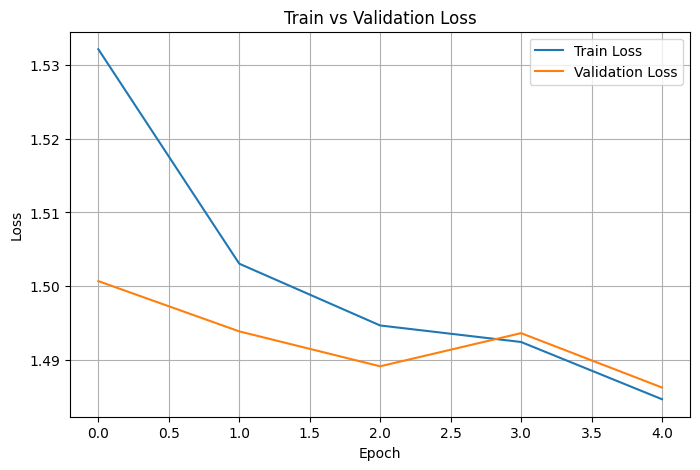

In [14]:
# Entrenamiento del modelo
model1 = train_model(MODEL_NAME, train_loader, val_loader, num_epochs=5, learning_rate=0.001)

Evaluating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]


Resultados de la evaluación
Accuracy: 0.2848
F1 Macro: 0.2699
F1 Micro: 0.2848
F1 Weighted: 0.2869
Precision Macro: 0.2695
Precision Micro: 0.2848
Precision Weighted: 0.2912
Recall Macro: 0.2746
Recall Micro: 0.2848
Recall Weighted: 0.2848
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.32      0.32       191
           1       0.30      0.25      0.27       190
           2       0.30      0.29      0.29       171
           3       0.30      0.30      0.30       181
           4       0.13      0.21      0.16        57

    accuracy                           0.28       790
   macro avg       0.27      0.27      0.27       790
weighted avg       0.29      0.28      0.29       790



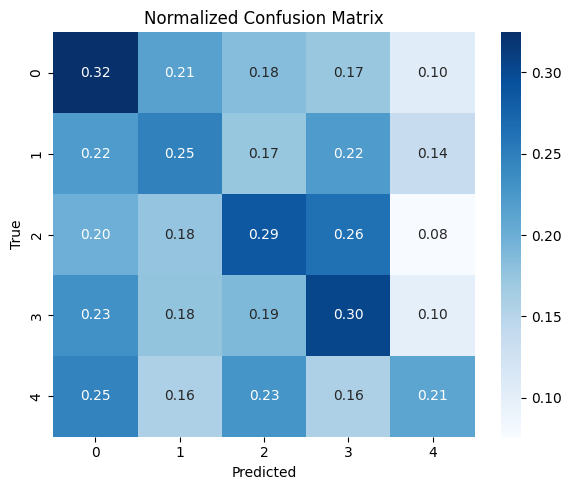

In [15]:
evaluate_model(model1, test_loader)


Dimensión embeddings bert 768
Parametros entrenables: 525313


Epoch 1/5: 100%|██████████████████████████████| 231/231 [01:12<00:00,  3.20it/s]


Epoch 1, Loss: 1.6158


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


Validation Loss: 1.6001, Accuracy: 0.2658, F1 Score: 0.2466


Epoch 2/5: 100%|██████████████████████████████| 231/231 [01:12<00:00,  3.19it/s]


Epoch 2, Loss: 1.6000


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.40it/s]


Validation Loss: 1.5866, Accuracy: 0.2722, F1 Score: 0.2561


Epoch 3/5: 100%|██████████████████████████████| 231/231 [01:12<00:00,  3.20it/s]


Epoch 3, Loss: 1.5909


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


Validation Loss: 1.5708, Accuracy: 0.2595, F1 Score: 0.2394


Epoch 4/5: 100%|██████████████████████████████| 231/231 [01:12<00:00,  3.21it/s]


Epoch 4, Loss: 1.5866


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.40it/s]


Validation Loss: 1.5663, Accuracy: 0.2759, F1 Score: 0.2541


Epoch 5/5: 100%|██████████████████████████████| 231/231 [01:12<00:00,  3.20it/s]


Epoch 5, Loss: 1.5892


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.40it/s]


Validation Loss: 1.5803, Accuracy: 0.2696, F1 Score: 0.2535


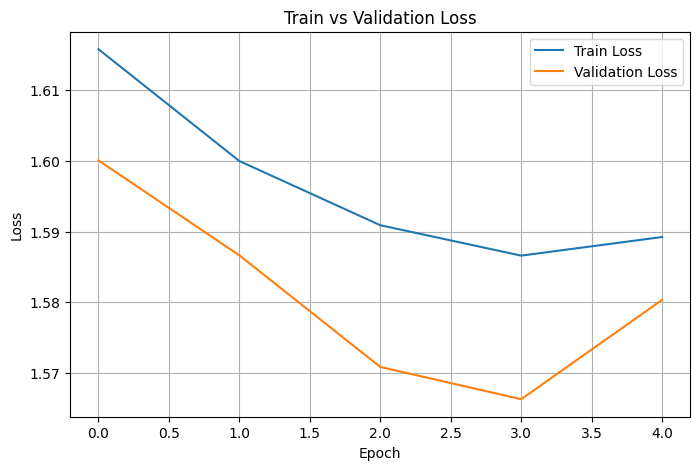

In [27]:
model2 = train_model(MODEL_NAME2, train_loader, val_loader, num_epochs=5, learning_rate=0.001)

Evaluating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.40it/s]


Resultados de la evaluación
Accuracy: 0.2658
F1 Macro: 0.2520
F1 Micro: 0.2658
F1 Weighted: 0.2660
Precision Macro: 0.2515
Precision Micro: 0.2658
Precision Weighted: 0.2667
Recall Macro: 0.2531
Recall Micro: 0.2658
Recall Weighted: 0.2658
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.26      0.27       191
           1       0.28      0.31      0.29       190
           2       0.28      0.27      0.27       171
           3       0.27      0.25      0.26       181
           4       0.16      0.18      0.17        57

    accuracy                           0.27       790
   macro avg       0.25      0.25      0.25       790
weighted avg       0.27      0.27      0.27       790



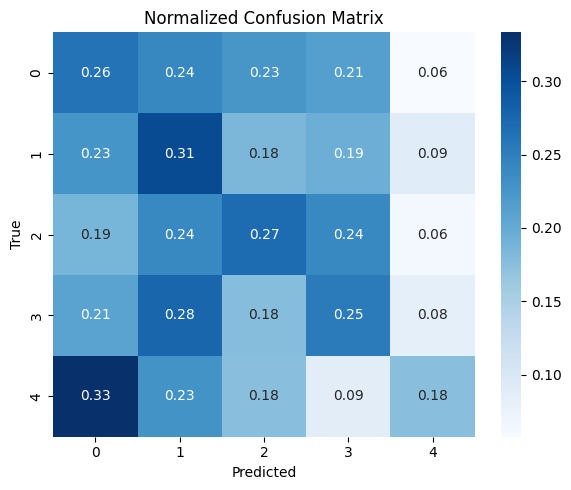

In [28]:
evaluate_model(model2, test_loader)

Dimensión embeddings bert 768
Parametros entrenables: 525313


Epoch 1/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.56it/s]


Epoch 1, Loss: 1.5812


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.80it/s]


Validation Loss: 1.5506, Accuracy: 0.2557, F1 Score: 0.2452


Epoch 2/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.56it/s]


Epoch 2, Loss: 1.5512


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.82it/s]


Validation Loss: 1.5447, Accuracy: 0.2468, F1 Score: 0.2371


Epoch 3/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.59it/s]


Epoch 3, Loss: 1.5515


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.83it/s]


Validation Loss: 1.5370, Accuracy: 0.2367, F1 Score: 0.2266


Epoch 4/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.60it/s]


Epoch 4, Loss: 1.5396


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.5330, Accuracy: 0.2354, F1 Score: 0.2237


Epoch 5/5: 100%|██████████████████████████████| 231/231 [01:04<00:00,  3.60it/s]


Epoch 5, Loss: 1.5459


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


Validation Loss: 1.5348, Accuracy: 0.2367, F1 Score: 0.2236


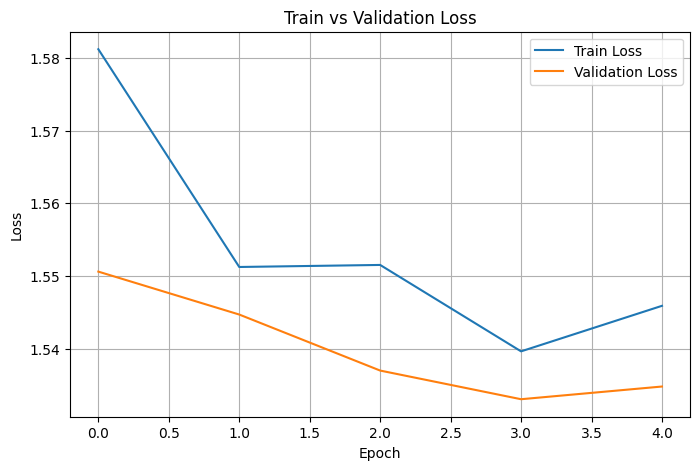

In [36]:
model3 = train_model(MODEL_NAME3, train_loader, val_loader, num_epochs=5, learning_rate=0.001)

Evaluating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


Resultados de la evaluación
Accuracy: 0.2506
F1 Macro: 0.2343
F1 Micro: 0.2506
F1 Weighted: 0.2515
Precision Macro: 0.2357
Precision Micro: 0.2506
Precision Weighted: 0.2551
Recall Macro: 0.2353
Recall Micro: 0.2506
Recall Weighted: 0.2506
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.24      0.26       191
           1       0.30      0.27      0.28       190
           2       0.25      0.23      0.24       171
           3       0.24      0.29      0.26       181
           4       0.12      0.14      0.13        57

    accuracy                           0.25       790
   macro avg       0.24      0.24      0.23       790
weighted avg       0.26      0.25      0.25       790



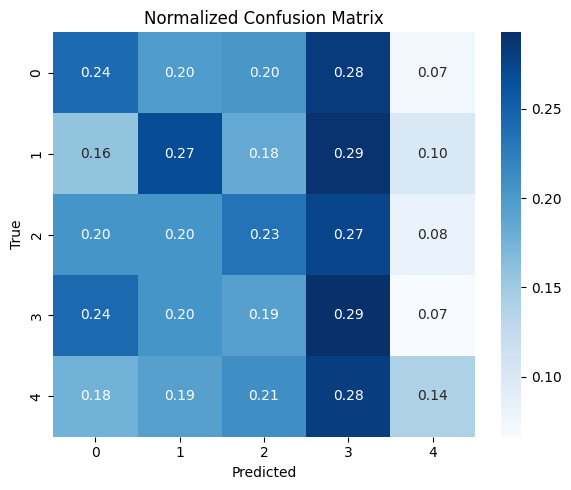

In [38]:
evaluate_model(model3, test_loader)

Notamos que ninguno de los modelos probados con esta configuración logra un rendimiento satisfactorio. Según las gráficas de pérdida incluso pareciese que los modelos se están sobreajustando rápidamente a los datos de entrenamiento, así se usen únicamente 5 épocas y dos capas densas para clasificación.

---
## Fine-tuning con k-capas descongeladas

La siguiente estrategia consiste en descongelar las últimas k capas de los encoders de manera que estas sean entrenables. Para ello definimos en primer lugar una función que descongele k capas.

In [ ]:
def unfreeze_last_transformer_layers(model, k=2):
    """
    Detecta automáticamente las capas Transformer dentro del encoder del modelo
    y descongela las últimas k capas.
    """

    # buscar listas de capas tipo ModuleList
    transformer_layers = None
    
    for name, module in model.named_modules():
        # buscamos el ModuleList de las capas
        if isinstance(module, torch.nn.ModuleList) and len(module) > 0:
            # detectar si parecen capas transformer (tienen self-attention)
            if hasattr(module[0], "attention") or hasattr(module[0], "self_attn"):
                transformer_layers = module
                print(f"Detectadas capas en: {name}")
                break

    if transformer_layers is None:
        raise ValueError("No se pudieron detectar las capas del Transformer en el modelo.")

    total_layers = len(transformer_layers)
    print(f"Total capas encontradas: {total_layers}. Descongelando últimas {k}.")

    # congelar todas primero
    for param in model.parameters():
        param.requires_grad = False

    # descongelar últimas k capas
    for layer in transformer_layers[-k:]:
        for param in layer.parameters():
            param.requires_grad = True


Ahora se define el modelo con la cabeza de clasificación y las capas de encoder entrenables.

In [17]:
class BertQAUnfrozenKLayers(nn.Module):
    def __init__(self, model_name, k_unfreeze, hidden_dim=512, dropout=0.2):
        super().__init__()

        # cargar el encoder de bert para obtener representaciones
        self.bert = AutoModel.from_pretrained(model_name)

        # descongelar las últimas k capas
        unfreeze_last_transformer_layers(self.bert, k=k_unfreeze)

        # obtener la dimensión de los embeddings
        bert_dim = self.bert.config.hidden_size  

        # crear la cabeza de clasificación
        self.classifier = nn.Sequential(
            nn.Linear(bert_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)  # a la salida del clasificador se obtiene un logit por opción - hay que pasar los 5 de cada respuesta por una softmax
        )

    def forward(self, input_ids, attention_mask):
        """
        este forward está adaptado para un batch de tamaño batch_size
        input_ids: (batch_size, num_choices, seq_len)
        attention_mask: (batch_size, num_choices, seq_len)
        """
        bsz, num_choices, seq_len = input_ids.size()

        # aplastamos las dos primeras dimensiones
        # para pasar todo de una sola vez por BERT
        input_ids = input_ids.view(bsz * num_choices, seq_len) # tratamos todas las combinaciones pregunta-opción como secuencias independientes
        attention_mask = attention_mask.view(bsz * num_choices, seq_len)

        # pasamos por BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # (bsz*num_choices, hidden_size)

        # pasamos por la cabeza
        logits = self.classifier(cls_output)  # (bsz*num_choices, 1)

        # volvemos a separar por pregunta
        logits = logits.view(bsz, num_choices)  # (bsz, num_choices)

        return logits


Entrenamos y evaluamos los modelos justo como en el anterior caso.

In [ ]:
def train_model_unfrozen(MODEL_NAME:str, train_loader:torch.utils.data.DataLoader, val_loader:torch.utils.data.DataLoader, num_epochs=5, learning_rate=1e-3, unfrozen_layers=2):
    """
    Función para entrenar el modelo con k capas descongeladas.
    Args:
    - MODEL_NAME (str): Nombre del modelo preentrenado.
    - train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
    - val_loader (DataLoader): DataLoader para el conjunto de validación.
    - num_epochs (int): Número de épocas para entrenar.
    - learning_rate (float): Tasa de aprendizaje para el optimizador.
    - unfrozen_layers (int): Número de capas descongeladas.
    Returns:
    - model (nn.Module): Modelo entrenado.
    """
    
    model = BertQAUnfrozenKLayers(MODEL_NAME, unfrozen_layers, hidden_dim=512, dropout=0.2) # esto cambia con respecto a la anterior funcion de entrenamiento
    print('Parametros entrenables:', sum(p.numel() for p in model.parameters() if p.requires_grad))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Mover tensores a gpu
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = batch['correct_answer'].to(device)

            # Forward
            logits = model(input_ids, attention_mask)

            # Calcular pérdida
            loss = criterion(logits, correct_answer)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Validación
        model.eval()
        val_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                correct_answer = batch['correct_answer'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, correct_answer)
                val_loss += loss.item()

                _, predicted = torch.max(logits, dim=1)
                preds.extend(predicted.cpu().numpy())
                labels.extend(correct_answer.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = np.mean(np.array(preds) == np.array(labels))
        f1 = f1_score(labels, preds, average='macro')

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Plot train loss y val loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 2.
Parametros entrenables: 14701057


Epoch 1/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 1, Loss: 1.5294


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.4974, Accuracy: 0.2684, F1 Score: 0.2513


Epoch 2/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 2, Loss: 1.5033


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.4960, Accuracy: 0.2797, F1 Score: 0.2631


Epoch 3/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 3, Loss: 1.4971


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.79it/s]


Validation Loss: 1.4900, Accuracy: 0.2772, F1 Score: 0.2605


Epoch 4/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 4, Loss: 1.4908


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.4884, Accuracy: 0.2810, F1 Score: 0.2621


Epoch 5/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 5, Loss: 1.4894


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]


Validation Loss: 1.4861, Accuracy: 0.2797, F1 Score: 0.2616


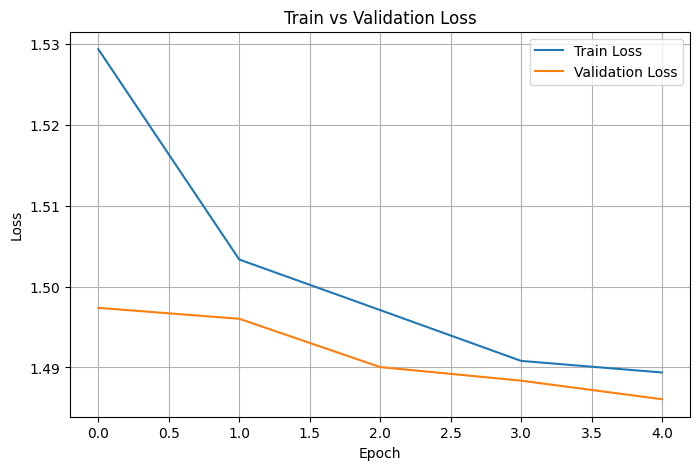

In [50]:
model1_uf = train_model_unfrozen(MODEL_NAME, train_loader, val_loader, num_epochs=5, learning_rate=0.001, unfrozen_layers=2)

Evaluating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Resultados de la evaluación
Accuracy: 0.2785
F1 Macro: 0.2662
F1 Micro: 0.2785
F1 Weighted: 0.2799
Precision Macro: 0.2651
Precision Micro: 0.2785
Precision Weighted: 0.2836
Recall Macro: 0.2712
Recall Micro: 0.2785
Recall Weighted: 0.2785
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.34       191
           1       0.30      0.25      0.27       190
           2       0.29      0.28      0.28       171
           3       0.25      0.26      0.26       181
           4       0.15      0.23      0.18        57

    accuracy                           0.28       790
   macro avg       0.27      0.27      0.27       790
weighted avg       0.28      0.28      0.28       790



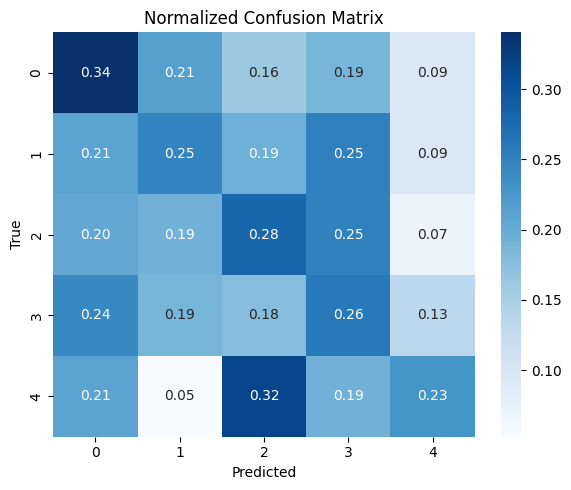

In [51]:
evaluate_model(model1_uf, test_loader)

Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 2.
Parametros entrenables: 14701057


Epoch 1/5: 100%|██████████████████████████████| 231/231 [01:22<00:00,  2.81it/s]


Epoch 1, Loss: 1.6122


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.42it/s]


Validation Loss: 1.5994, Accuracy: 0.2696, F1 Score: 0.2537


Epoch 2/5: 100%|██████████████████████████████| 231/231 [01:22<00:00,  2.80it/s]


Epoch 2, Loss: 1.6024


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


Validation Loss: 1.5921, Accuracy: 0.2506, F1 Score: 0.2320


Epoch 3/5: 100%|██████████████████████████████| 231/231 [01:22<00:00,  2.80it/s]


Epoch 3, Loss: 1.5944


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


Validation Loss: 1.5703, Accuracy: 0.2747, F1 Score: 0.2582


Epoch 4/5: 100%|██████████████████████████████| 231/231 [01:22<00:00,  2.80it/s]


Epoch 4, Loss: 1.5863


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


Validation Loss: 1.5774, Accuracy: 0.2570, F1 Score: 0.2423


Epoch 5/5: 100%|██████████████████████████████| 231/231 [01:22<00:00,  2.80it/s]


Epoch 5, Loss: 1.5849


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


Validation Loss: 1.5677, Accuracy: 0.2671, F1 Score: 0.2473


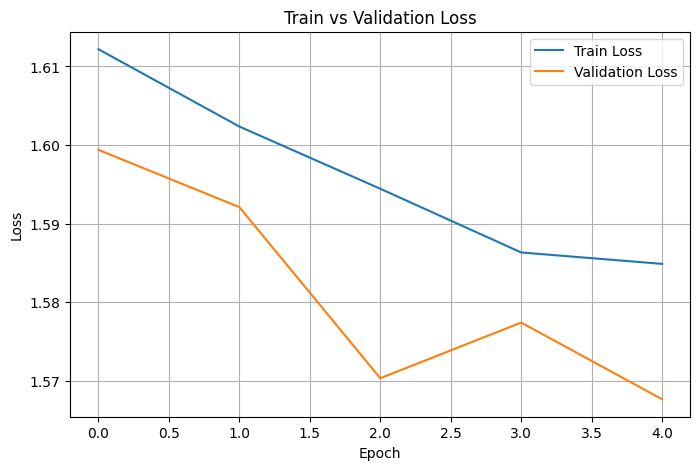

In [52]:
model2_uf = train_model_unfrozen(MODEL_NAME2, train_loader, val_loader, num_epochs=5, learning_rate=0.001, unfrozen_layers=2)

Evaluating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.43it/s]


Resultados de la evaluación
Accuracy: 0.2861
F1 Macro: 0.2710
F1 Micro: 0.2861
F1 Weighted: 0.2862
Precision Macro: 0.2702
Precision Micro: 0.2861
Precision Weighted: 0.2870
Recall Macro: 0.2728
Recall Micro: 0.2861
Recall Weighted: 0.2861
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.31      0.32       191
           1       0.30      0.32      0.31       190
           2       0.30      0.30      0.30       171
           3       0.26      0.24      0.25       181
           4       0.17      0.19      0.18        57

    accuracy                           0.29       790
   macro avg       0.27      0.27      0.27       790
weighted avg       0.29      0.29      0.29       790



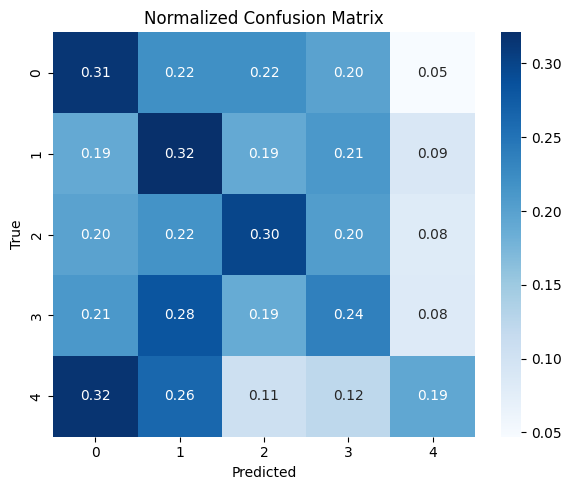

In [53]:
evaluate_model(model2_uf, test_loader)

Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 2.
Parametros entrenables: 14701057


Epoch 1/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 1, Loss: 1.5817


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.5472, Accuracy: 0.2443, F1 Score: 0.2352


Epoch 2/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 2, Loss: 1.5586


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.5482, Accuracy: 0.2367, F1 Score: 0.2270


Epoch 3/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 3, Loss: 1.5543


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.5448, Accuracy: 0.2342, F1 Score: 0.2192


Epoch 4/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 4, Loss: 1.5458


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.5477, Accuracy: 0.2291, F1 Score: 0.2203


Epoch 5/5: 100%|██████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 5, Loss: 1.5414


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.5389, Accuracy: 0.2278, F1 Score: 0.2214


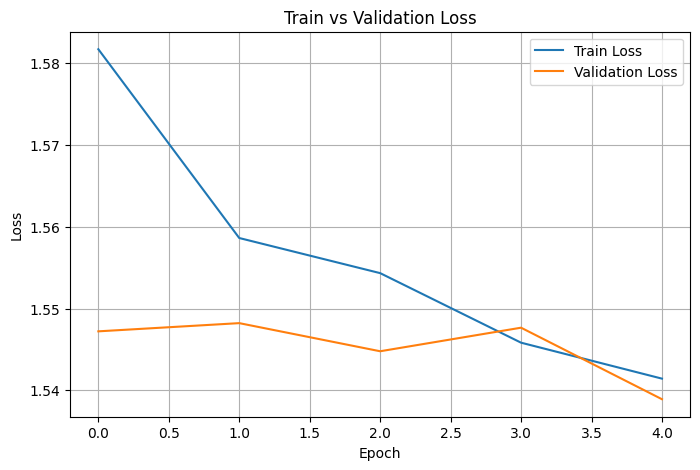

In [54]:
model3_uf = train_model_unfrozen(MODEL_NAME3, train_loader, val_loader, num_epochs=5, learning_rate=0.001, unfrozen_layers=2)

Evaluating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


Resultados de la evaluación
Accuracy: 0.2734
F1 Macro: 0.2546
F1 Micro: 0.2734
F1 Weighted: 0.2748
Precision Macro: 0.2557
Precision Micro: 0.2734
Precision Weighted: 0.2775
Recall Macro: 0.2550
Recall Micro: 0.2734
Recall Weighted: 0.2734
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.29      0.31       191
           1       0.28      0.28      0.28       190
           2       0.29      0.27      0.28       171
           3       0.26      0.29      0.27       181
           4       0.12      0.14      0.13        57

    accuracy                           0.27       790
   macro avg       0.26      0.25      0.25       790
weighted avg       0.28      0.27      0.27       790



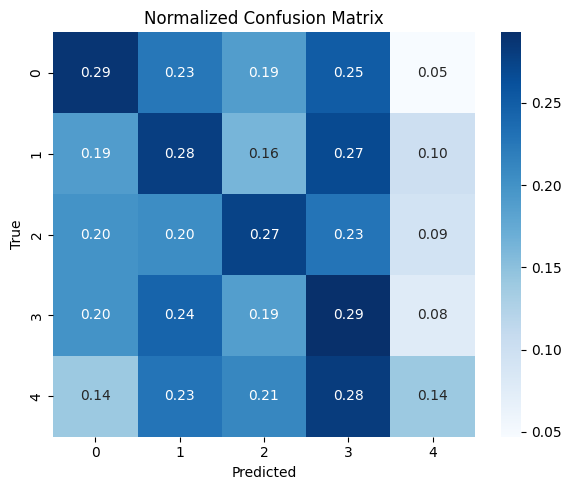

In [55]:
evaluate_model(model3_uf, test_loader)

Podemos notar como al descongelar las últimas 2 capas de los encoders el rendimiento mejora significativamente en comparación con el caso anterior, aunque sigue siendo insuficiente para la tarea planteada. Se observa además que el modelo basado en RoBERTa obtiene un rendimiento ligeramente superior a los otros dos modelos.



## Warmup de la tasa de aprendizaje
Como prueba adicional a la estrategia anterior, se implementa un warmup de la tasa de aprendizaje durante las primeras épocas de entrenamiento. Esto puede ayudar a estabilizar el proceso de optimización y mejorar el rendimiento del modelo.

In [ ]:
def train_model_unfrozen_warmup(MODEL_NAME:str, train_loader:torch.utils.data.DataLoader, val_loader:torch.utils.data.DataLoader, num_epochs=10, learning_rate=2e-5, unfrozen_layers=2):
    """
    Función para entrenar el modelo con k capas descongeladas y warmup de la tasa de aprendizaje.
    Args:
    - MODEL_NAME (str): Nombre del modelo preentrenado.
    - train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
    - val_loader (DataLoader): DataLoader para el conjunto de validación.
    - num_epochs (int): Número de épocas para entrenar.
    - learning_rate (float): Tasa de aprendizaje para el optimizador.
    - unfrozen_layers (int): Número de capas descongeladas.
    Returns:
    - model (nn.Module): Modelo entrenado.
    """
    model = BertQAUnfrozenKLayers(MODEL_NAME, unfrozen_layers, hidden_dim=512, dropout=0.2) 
    print('Parametros entrenables:', sum(p.numel() for p in model.parameters() if p.requires_grad))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # definimos el numero de epocas de warmup - 30% del total de pasos de entrenamiento
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(0.3 * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Mover tensores a gpu
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = batch['correct_answer'].to(device)

            # Forward
            logits = model(input_ids, attention_mask)

            # Calcular pérdida
            loss = criterion(logits, correct_answer)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Validación
        model.eval()
        val_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                correct_answer = batch['correct_answer'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, correct_answer)
                val_loss += loss.item()

                _, predicted = torch.max(logits, dim=1)
                preds.extend(predicted.cpu().numpy())
                labels.extend(correct_answer.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = np.mean(np.array(preds) == np.array(labels))
        f1 = f1_score(labels, preds, average='macro')

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    # Plot train loss y val loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 5.
Parametros entrenables: 35964673


Epoch 1/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 1, Loss: 1.5595


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 1.5025, Accuracy: 0.2785, F1 Score: 0.2655


Epoch 2/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 2, Loss: 1.4856


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 1.4806, Accuracy: 0.2924, F1 Score: 0.2871


Epoch 3/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 3, Loss: 1.4461


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.4748, Accuracy: 0.3013, F1 Score: 0.2909


Epoch 4/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 4, Loss: 1.3760


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 1.5319, Accuracy: 0.2848, F1 Score: 0.2781


Epoch 5/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 5, Loss: 1.2616


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Validation Loss: 1.6250, Accuracy: 0.2620, F1 Score: 0.2615


Epoch 6/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 6, Loss: 1.0933


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.7253, Accuracy: 0.2557, F1 Score: 0.2530


Epoch 7/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 7, Loss: 0.9297


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 1.9167, Accuracy: 0.2544, F1 Score: 0.2520


Epoch 8/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 8, Loss: 0.8212


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 2.1049, Accuracy: 0.2519, F1 Score: 0.2467


Epoch 9/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 9, Loss: 0.7509


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Validation Loss: 2.2080, Accuracy: 0.2481, F1 Score: 0.2416


Epoch 10/10: 100%|████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 10, Loss: 0.7200


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 2.2393, Accuracy: 0.2494, F1 Score: 0.2428


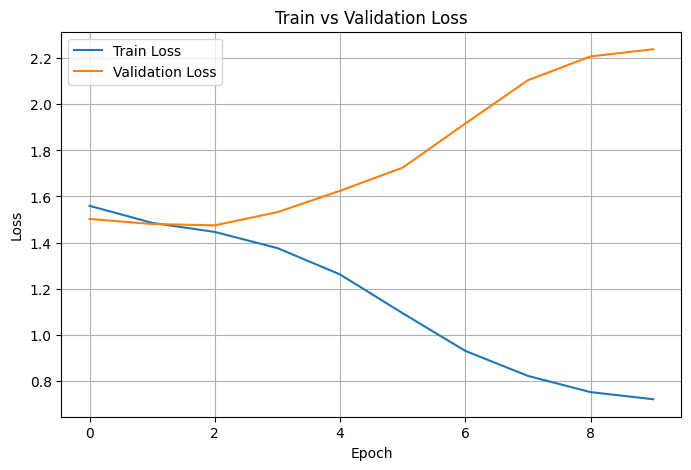

In [62]:
model_uf_warmup = train_model_unfrozen_warmup(MODEL_NAME, train_loader, val_loader, num_epochs=10, learning_rate=2e-5, unfrozen_layers=5)

Evaluating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Resultados de la evaluación
Accuracy: 0.2987
F1 Macro: 0.2962
F1 Micro: 0.2987
F1 Weighted: 0.2985
Precision Macro: 0.2923
Precision Micro: 0.2987
Precision Weighted: 0.3006
Recall Macro: 0.3041
Recall Micro: 0.2987
Recall Weighted: 0.2987
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.28      0.29       191
           1       0.30      0.27      0.28       190
           2       0.30      0.31      0.31       171
           3       0.31      0.33      0.32       181
           4       0.24      0.33      0.28        57

    accuracy                           0.30       790
   macro avg       0.29      0.30      0.30       790
weighted avg       0.30      0.30      0.30       790



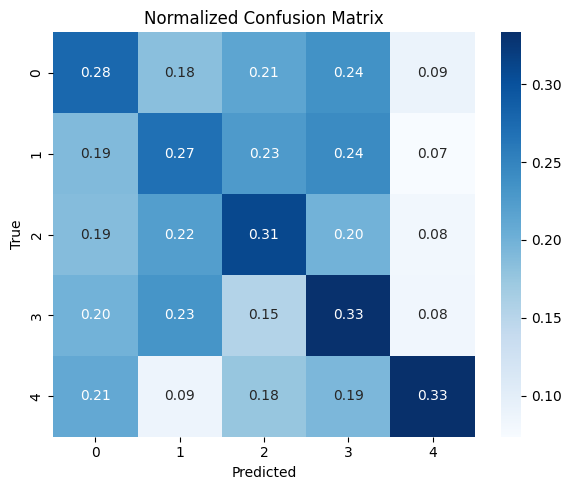

In [63]:
evaluate_model(model_uf_warmup, test_loader)

A pesar de estar sobreajustado según las graficas de pérdida, el modelo con warmup logra un rendimiento ligeramente superior al modelo sin warmup.

Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 2.
Parametros entrenables: 14701057


Epoch 1/10: 100%|█████████████████████████████| 231/231 [01:16<00:00,  3.02it/s]


Epoch 1, Loss: 1.6040


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]


Validation Loss: 1.5768, Accuracy: 0.2684, F1 Score: 0.2595


Epoch 2/10: 100%|█████████████████████████████| 231/231 [01:15<00:00,  3.05it/s]


Epoch 2, Loss: 1.5169


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.83it/s]


Validation Loss: 1.4997, Accuracy: 0.2633, F1 Score: 0.2525


Epoch 3/10: 100%|█████████████████████████████| 231/231 [01:14<00:00,  3.09it/s]


Epoch 3, Loss: 1.4890


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.84it/s]


Validation Loss: 1.4937, Accuracy: 0.2709, F1 Score: 0.2553


Epoch 4/10: 100%|█████████████████████████████| 231/231 [01:13<00:00,  3.12it/s]


Epoch 4, Loss: 1.4827


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.4905, Accuracy: 0.2734, F1 Score: 0.2637


Epoch 5/10: 100%|█████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 5, Loss: 1.4695


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.89it/s]


Validation Loss: 1.4913, Accuracy: 0.2557, F1 Score: 0.2433


Epoch 6/10: 100%|█████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 6, Loss: 1.4723


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.4908, Accuracy: 0.2696, F1 Score: 0.2648


Epoch 7/10: 100%|█████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 7, Loss: 1.4648


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.4941, Accuracy: 0.2620, F1 Score: 0.2584


Epoch 8/10: 100%|█████████████████████████████| 231/231 [01:13<00:00,  3.13it/s]


Epoch 8, Loss: 1.4607


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Validation Loss: 1.4936, Accuracy: 0.2658, F1 Score: 0.2631


Epoch 9/10: 100%|█████████████████████████████| 231/231 [01:13<00:00,  3.14it/s]


Epoch 9, Loss: 1.4546


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.4978, Accuracy: 0.2582, F1 Score: 0.2548


Epoch 10/10: 100%|████████████████████████████| 231/231 [01:13<00:00,  3.13it/s]


Epoch 10, Loss: 1.4564


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Validation Loss: 1.4972, Accuracy: 0.2557, F1 Score: 0.2519


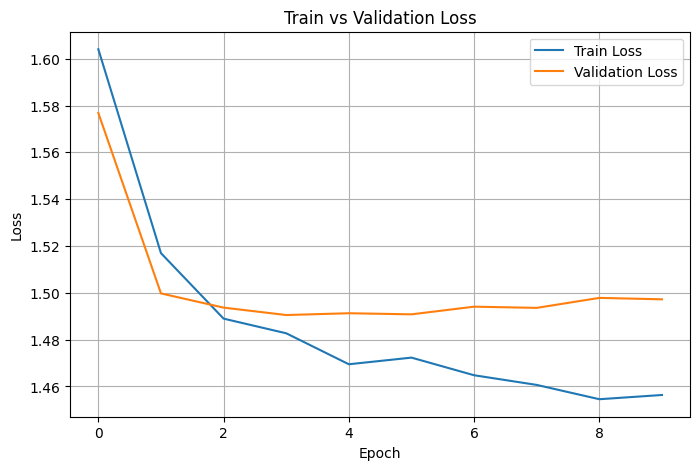

In [58]:
model3_uf_warmup = train_model_unfrozen_warmup(MODEL_NAME3, train_loader, val_loader, num_epochs=10, learning_rate=2e-5, unfrozen_layers=2)

Evaluating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Resultados de la evaluación
Accuracy: 0.2797
F1 Macro: 0.2533
F1 Micro: 0.2797
F1 Weighted: 0.2812
Precision Macro: 0.2547
Precision Micro: 0.2797
Precision Weighted: 0.2839
Recall Macro: 0.2529
Recall Micro: 0.2797
Recall Weighted: 0.2797
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       191
           1       0.33      0.29      0.31       190
           2       0.27      0.27      0.27       171
           3       0.26      0.30      0.28       181
           4       0.08      0.09      0.08        57

    accuracy                           0.28       790
   macro avg       0.25      0.25      0.25       790
weighted avg       0.28      0.28      0.28       790



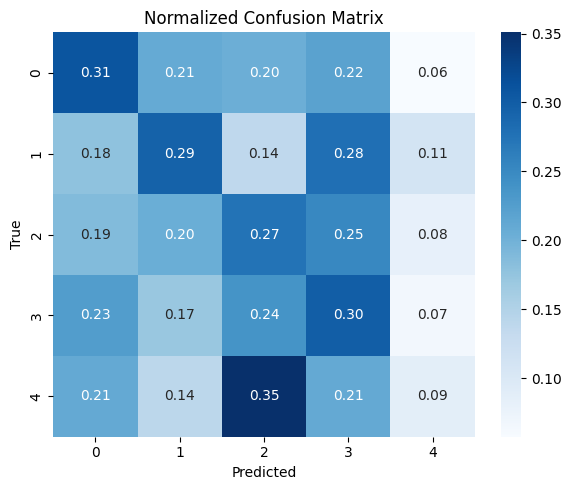

In [59]:
evaluate_model(model3_uf_warmup, test_loader)

Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 5.
Parametros entrenables: 35964673


Epoch 1/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 1, Loss: 1.5923


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Validation Loss: 1.5279, Accuracy: 0.2532, F1 Score: 0.2409


Epoch 2/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.32it/s]


Epoch 2, Loss: 1.5030


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Validation Loss: 1.4972, Accuracy: 0.2506, F1 Score: 0.2447


Epoch 3/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 3, Loss: 1.4841


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.4973, Accuracy: 0.2519, F1 Score: 0.2488


Epoch 4/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 4, Loss: 1.4659


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.4937, Accuracy: 0.2342, F1 Score: 0.2328


Epoch 5/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 5, Loss: 1.4397


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.5137, Accuracy: 0.2481, F1 Score: 0.2489


Epoch 6/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 6, Loss: 1.3975


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Validation Loss: 1.5532, Accuracy: 0.2544, F1 Score: 0.2546


Epoch 7/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 7, Loss: 1.3463


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


Validation Loss: 1.6366, Accuracy: 0.2278, F1 Score: 0.2278


Epoch 8/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 8, Loss: 1.3106


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.6882, Accuracy: 0.2405, F1 Score: 0.2402


Epoch 9/10: 100%|█████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 9, Loss: 1.2721


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.6927, Accuracy: 0.2380, F1 Score: 0.2352


Epoch 10/10: 100%|████████████████████████████| 231/231 [01:39<00:00,  2.33it/s]


Epoch 10, Loss: 1.2529


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


Validation Loss: 1.7150, Accuracy: 0.2380, F1 Score: 0.2389


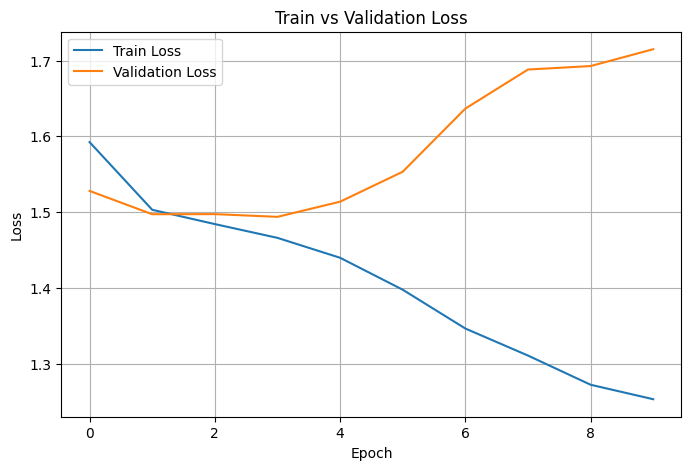

In [60]:
# mismo modelo descongelando 5 capas
model3_uf_warmup = train_model_unfrozen_warmup(MODEL_NAME3, train_loader, val_loader, num_epochs=10, learning_rate=2e-5, unfrozen_layers=5)

Evaluating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


Resultados de la evaluación
Accuracy: 0.2949
F1 Macro: 0.2800
F1 Micro: 0.2949
F1 Weighted: 0.2963
Precision Macro: 0.2795
Precision Micro: 0.2949
Precision Weighted: 0.2999
Recall Macro: 0.2834
Recall Micro: 0.2949
Recall Weighted: 0.2949
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.28      0.30       191
           1       0.34      0.28      0.31       190
           2       0.26      0.27      0.26       171
           3       0.34      0.36      0.35       181
           4       0.16      0.21      0.18        57

    accuracy                           0.29       790
   macro avg       0.28      0.28      0.28       790
weighted avg       0.30      0.29      0.30       790



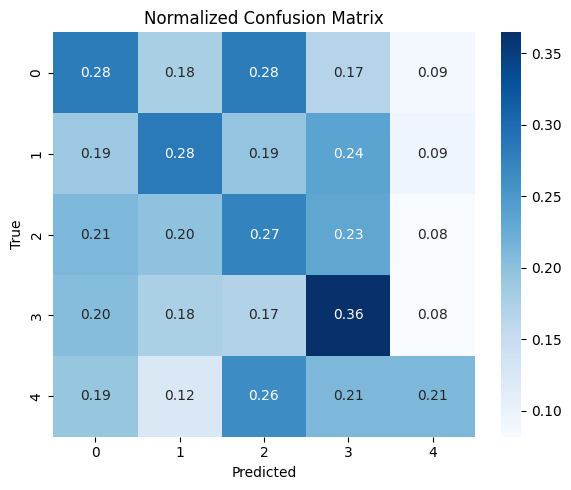

In [61]:
evaluate_model(model3_uf_warmup, test_loader)

Nuevamente, a pesar del sobreajuste, el modelo con warmup muestra una ligera mejora en el rendimiento en comparación con el modelo sin warmup en el conjunto de test.


---
## Descongelar todas las capas
Finalmente, se prueba descongelar todas las capas de los encoders y entrenarlas completamente junto con las capas densas de clasificación. En este caso es muy importante usar un learning rate muy bajo para evitar que los pesos preentrenados se modifiquen demasiado rápido y se pierda el conocimiento adquirido durante el preentrenamiento. Adicionalmente, se mantiene el warmup de la tasa de aprendizaje al notar mejoras con los anteriores experimentos, se implementa un early stopping para evitar sobreajuste y se guarda siempre el mejor modelo basado en el rendimiento en el conjunto de validación.

In [ ]:
def train_model_fully_unfrozen(MODEL_NAME:str, train_loader:DataLoader, val_loader:DataLoader, num_epochs=10, learning_rate=2e-5, patience=3):
    """
    Función para entrenar el modelo con todas las capas descongeladas y early stopping.
    Args:
    - MODEL_NAME (str): Nombre del modelo preentrenado.
    - train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
    - val_loader (DataLoader): DataLoader para el conjunto de validación.
    - num_epochs (int): Número de épocas para entrenar.
    - learning_rate (float): Tasa de aprendizaje para el optimizador.
    - patience (int): Número de épocas sin mejora para activar el early stopping.
    Returns:
    - model (nn.Module): Modelo entrenado."""

    # no se pasan capas para descongelar, sino que se descingelan todos los pesos
    model = AutoModel.from_pretrained(MODEL_NAME)
    model = BertQAUnfrozenKLayers(MODEL_NAME, 0, hidden_dim=512, dropout=0.2)

    # descongelar
    for p in model.parameters():
        p.requires_grad = True

    print('Parametros entrenables:', sum(p.numel() for p in model.parameters() if p.requires_grad))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # definimos el numero de epocas de warmup
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(0.1 * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    model.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Mover tensores a gpu
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = batch['correct_answer'].to(device)

            # Forward
            logits = model(input_ids, attention_mask)

            # Calcular pérdida
            loss = criterion(logits, correct_answer)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Validación
        model.eval()
        val_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                correct_answer = batch['correct_answer'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, correct_answer)
                val_loss += loss.item()

                _, predicted = torch.max(logits, dim=1)
                preds.extend(predicted.cpu().numpy())
                labels.extend(correct_answer.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = np.mean(np.array(preds) == np.array(labels))
        f1 = f1_score(labels, preds, average='macro')

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

        # early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            print(f"EarlyStopping: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Deteniendo entrenamiento por Early Stopping.")
                break

    # guardar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot train loss y val loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


A continuación se presentan varios resultados siguiendo la estrategia descrita anteriormente, variando modelos, epocas y paciencia del early stopping.

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 0.
Parametros entrenables: 110376193


Epoch 1/10: 100%|█████████████████████████████| 231/231 [02:44<00:00,  1.40it/s]


Epoch 1, Loss: 1.5492


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.69it/s]


Validation Loss: 1.5002, Accuracy: 0.2785, F1 Score: 0.2655


Epoch 2/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 2, Loss: 1.4766


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.72it/s]


Validation Loss: 1.4877, Accuracy: 0.2620, F1 Score: 0.2516


Epoch 3/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 3, Loss: 1.3297


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Validation Loss: 1.5818, Accuracy: 0.2532, F1 Score: 0.2467
EarlyStopping: 1/3


Epoch 4/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 4, Loss: 0.9380


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 1.9745, Accuracy: 0.2823, F1 Score: 0.2746
EarlyStopping: 2/3


Epoch 5/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 5, Loss: 0.4995


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 2.6669, Accuracy: 0.2671, F1 Score: 0.2588
EarlyStopping: 3/3
Deteniendo entrenamiento por Early Stopping.


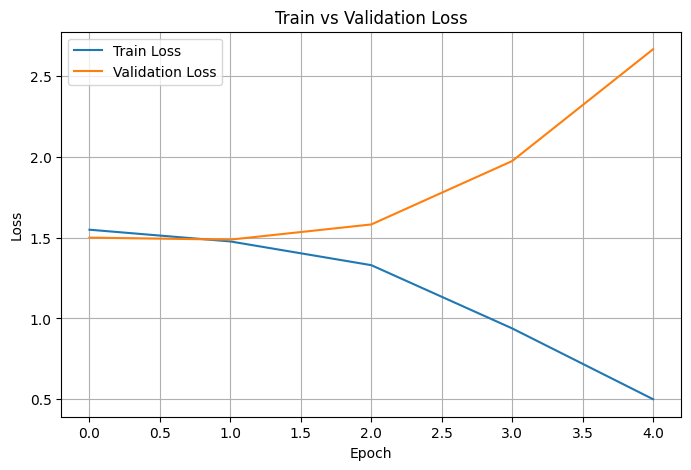

In [69]:
model_fully_unfrozen = train_model_fully_unfrozen(MODEL_NAME, train_loader, val_loader)

Evaluating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.78it/s]


Resultados de la evaluación
Accuracy: 0.3127
F1 Macro: 0.3026
F1 Micro: 0.3127
F1 Weighted: 0.3143
Precision Macro: 0.3010
Precision Micro: 0.3127
Precision Weighted: 0.3179
Recall Macro: 0.3078
Recall Micro: 0.3127
Recall Weighted: 0.3127
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.33      0.32       191
           1       0.37      0.34      0.35       190
           2       0.33      0.30      0.32       171
           3       0.30      0.29      0.29       181
           4       0.20      0.28      0.23        57

    accuracy                           0.31       790
   macro avg       0.30      0.31      0.30       790
weighted avg       0.32      0.31      0.31       790



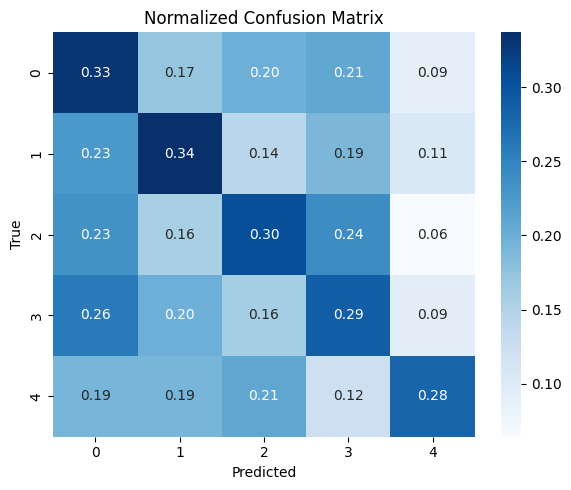

In [70]:
evaluate_model(model_fully_unfrozen, test_loader)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 0.
Parametros entrenables: 110376193


Epoch 1/10: 100%|█████████████████████████████| 231/231 [02:42<00:00,  1.42it/s]


Epoch 1, Loss: 1.5534


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.72it/s]


Validation Loss: 1.4980, Accuracy: 0.2734, F1 Score: 0.2630


Epoch 2/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 2, Loss: 1.4720


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Validation Loss: 1.4734, Accuracy: 0.2962, F1 Score: 0.2914


Epoch 3/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 3, Loss: 1.3212


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.77it/s]


Validation Loss: 1.5937, Accuracy: 0.2722, F1 Score: 0.2626
EarlyStopping: 1/10


Epoch 4/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 4, Loss: 0.8888


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 2.0006, Accuracy: 0.2709, F1 Score: 0.2648
EarlyStopping: 2/10


Epoch 5/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 5, Loss: 0.4925


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 2.8618, Accuracy: 0.2911, F1 Score: 0.2813
EarlyStopping: 3/10


Epoch 6/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 6, Loss: 0.2853


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Validation Loss: 3.2214, Accuracy: 0.2911, F1 Score: 0.2889
EarlyStopping: 4/10


Epoch 7/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 7, Loss: 0.1902


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Validation Loss: 3.7625, Accuracy: 0.2861, F1 Score: 0.2744
EarlyStopping: 5/10


Epoch 8/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 8, Loss: 0.1412


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 3.8321, Accuracy: 0.2886, F1 Score: 0.2763
EarlyStopping: 6/10


Epoch 9/10: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 9, Loss: 0.1219


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 3.9434, Accuracy: 0.2848, F1 Score: 0.2745
EarlyStopping: 7/10


Epoch 10/10: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 10, Loss: 0.0996


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Validation Loss: 4.0372, Accuracy: 0.2924, F1 Score: 0.2826
EarlyStopping: 8/10


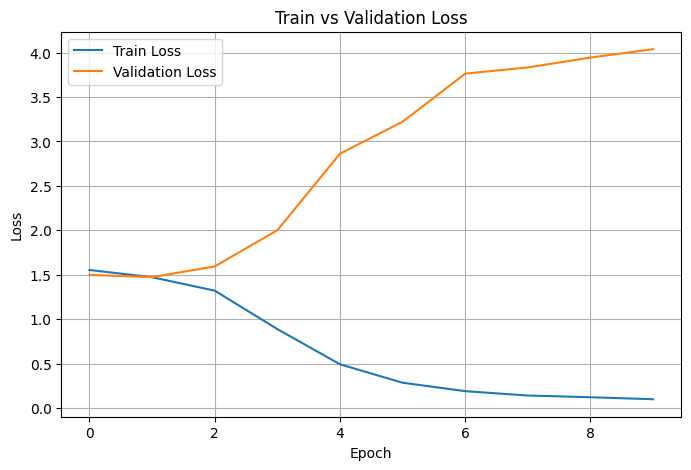

In [75]:
model_fully_unfrozenv2 = train_model_fully_unfrozen(MODEL_NAME, train_loader, val_loader, patience=10)

Evaluating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Resultados de la evaluación
Accuracy: 0.3114
F1 Macro: 0.3045
F1 Micro: 0.3114
F1 Weighted: 0.3119
Precision Macro: 0.3014
Precision Micro: 0.3114
Precision Weighted: 0.3138
Recall Macro: 0.3102
Recall Micro: 0.3114
Recall Weighted: 0.3114
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       191
           1       0.32      0.29      0.30       190
           2       0.33      0.35      0.34       171
           3       0.31      0.31      0.31       181
           4       0.22      0.30      0.26        57

    accuracy                           0.31       790
   macro avg       0.30      0.31      0.30       790
weighted avg       0.31      0.31      0.31       790



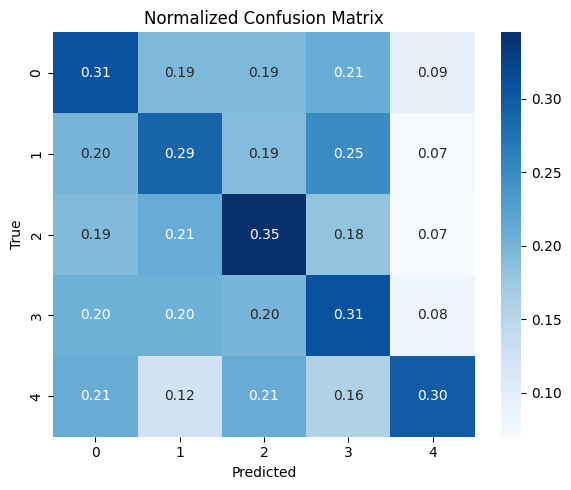

In [76]:
evaluate_model(model_fully_unfrozenv2, test_loader)

In [77]:
torch.save(model_fully_unfrozenv2.state_dict(), "best_model_bert_unfrozen_10_epochs.pth")

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 0.
Parametros entrenables: 110376193


Epoch 1/30: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.43it/s]


Epoch 1, Loss: 1.5796


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 1.5135, Accuracy: 0.2544, F1 Score: 0.2364


Epoch 2/30: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 2, Loss: 1.4973


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 1.4963, Accuracy: 0.2772, F1 Score: 0.2639


Epoch 3/30: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 3, Loss: 1.4390


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 1.4807, Accuracy: 0.2924, F1 Score: 0.2975


Epoch 4/30: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 4, Loss: 1.2101


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.60it/s]


Validation Loss: 1.6083, Accuracy: 0.2823, F1 Score: 0.2813
EarlyStopping: 1/20


Epoch 5/30: 100%|█████████████████████████████| 231/231 [02:43<00:00,  1.41it/s]


Epoch 5, Loss: 0.7484


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.73it/s]


Validation Loss: 2.2924, Accuracy: 0.2975, F1 Score: 0.2940
EarlyStopping: 2/20


Epoch 6/30: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 6, Loss: 0.3862


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 2.7424, Accuracy: 0.2924, F1 Score: 0.2856
EarlyStopping: 3/20


Epoch 7/30: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 7, Loss: 0.2459


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.64it/s]


Validation Loss: 3.3737, Accuracy: 0.2772, F1 Score: 0.2654
EarlyStopping: 4/20


Epoch 8/30: 100%|█████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 8, Loss: 0.1792


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 3.4936, Accuracy: 0.2734, F1 Score: 0.2700
EarlyStopping: 5/20


Epoch 9/30: 100%|█████████████████████████████| 231/231 [02:44<00:00,  1.40it/s]


Epoch 9, Loss: 0.1169


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 4.1243, Accuracy: 0.2987, F1 Score: 0.2912
EarlyStopping: 6/20


Epoch 10/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 10, Loss: 0.0774


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 4.7141, Accuracy: 0.2937, F1 Score: 0.2880
EarlyStopping: 7/20


Epoch 11/30: 100%|████████████████████████████| 231/231 [02:43<00:00,  1.41it/s]


Epoch 11, Loss: 0.0649


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.55it/s]


Validation Loss: 4.5247, Accuracy: 0.2772, F1 Score: 0.2703
EarlyStopping: 8/20


Epoch 12/30: 100%|████████████████████████████| 231/231 [02:43<00:00,  1.41it/s]


Epoch 12, Loss: 0.0605


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Validation Loss: 4.7533, Accuracy: 0.2772, F1 Score: 0.2756
EarlyStopping: 9/20


Epoch 13/30: 100%|████████████████████████████| 231/231 [02:44<00:00,  1.41it/s]


Epoch 13, Loss: 0.0539


Validating: 100%|███████████████████████████████| 50/50 [00:14<00:00,  3.53it/s]


Validation Loss: 4.8899, Accuracy: 0.2759, F1 Score: 0.2645
EarlyStopping: 10/20


Epoch 14/30: 100%|████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 14, Loss: 0.0388


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 4.9312, Accuracy: 0.2861, F1 Score: 0.2793
EarlyStopping: 11/20


Epoch 15/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 15, Loss: 0.0333


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 5.0374, Accuracy: 0.2873, F1 Score: 0.2788
EarlyStopping: 12/20


Epoch 16/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 16, Loss: 0.0356


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 4.8950, Accuracy: 0.3038, F1 Score: 0.2980
EarlyStopping: 13/20


Epoch 17/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 17, Loss: 0.0409


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Validation Loss: 5.0405, Accuracy: 0.2975, F1 Score: 0.2906
EarlyStopping: 14/20


Epoch 18/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 18, Loss: 0.0315


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 5.4600, Accuracy: 0.2949, F1 Score: 0.2873
EarlyStopping: 15/20


Epoch 19/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 19, Loss: 0.0295


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 5.2783, Accuracy: 0.2937, F1 Score: 0.2859
EarlyStopping: 16/20


Epoch 20/30: 100%|████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 20, Loss: 0.0213


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.58it/s]


Validation Loss: 5.4782, Accuracy: 0.3000, F1 Score: 0.2920
EarlyStopping: 17/20


Epoch 21/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 21, Loss: 0.0202


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.74it/s]


Validation Loss: 5.7315, Accuracy: 0.2911, F1 Score: 0.2845
EarlyStopping: 18/20


Epoch 22/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 22, Loss: 0.0187


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.76it/s]


Validation Loss: 5.6826, Accuracy: 0.2886, F1 Score: 0.2775
EarlyStopping: 19/20


Epoch 23/30: 100%|████████████████████████████| 231/231 [02:40<00:00,  1.44it/s]


Epoch 23, Loss: 0.0194


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


Validation Loss: 5.5198, Accuracy: 0.2949, F1 Score: 0.2860
EarlyStopping: 20/20
Deteniendo entrenamiento por Early Stopping.


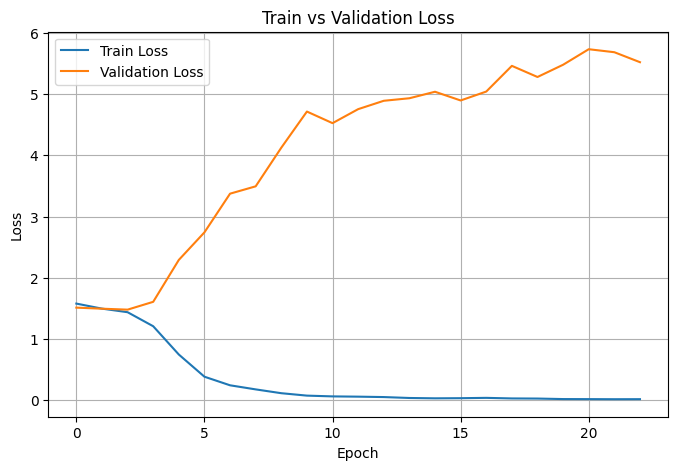

In [21]:
model_fully_unfrozenv3 = train_model_fully_unfrozen(MODEL_NAME, train_loader, val_loader, patience=20, num_epochs = 30)

Evaluating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.67it/s]


Resultados de la evaluación
Accuracy: 0.3101
F1 Macro: 0.3019
F1 Micro: 0.3101
F1 Weighted: 0.3104
Precision Macro: 0.2995
Precision Micro: 0.3101
Precision Weighted: 0.3122
Recall Macro: 0.3068
Recall Micro: 0.3101
Recall Weighted: 0.3101
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.31      0.31       191
           1       0.33      0.28      0.31       190
           2       0.33      0.36      0.34       171
           3       0.31      0.30      0.30       181
           4       0.22      0.28      0.25        57

    accuracy                           0.31       790
   macro avg       0.30      0.31      0.30       790
weighted avg       0.31      0.31      0.31       790



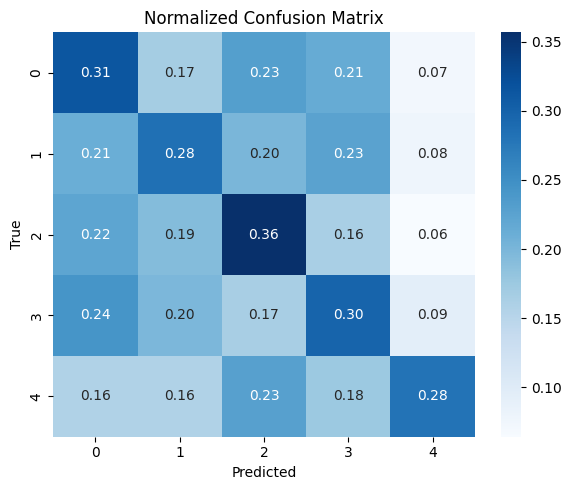

In [22]:
evaluate_model(model_fully_unfrozenv3, test_loader)

Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 0.
Parametros entrenables: 126503425


Epoch 1/10: 100%|█████████████████████████████| 231/231 [02:42<00:00,  1.42it/s]


Epoch 1, Loss: 1.5838


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.83it/s]


Validation Loss: 1.5182, Accuracy: 0.2468, F1 Score: 0.2333


Epoch 2/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 2, Loss: 1.5036


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.84it/s]


Validation Loss: 1.4963, Accuracy: 0.2772, F1 Score: 0.2655


Epoch 3/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 3, Loss: 1.4639


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.83it/s]


Validation Loss: 1.5121, Accuracy: 0.2620, F1 Score: 0.2554
EarlyStopping: 1/3


Epoch 4/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 4, Loss: 1.3901


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.5433, Accuracy: 0.2608, F1 Score: 0.2514
EarlyStopping: 2/3


Epoch 5/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 5, Loss: 1.2416


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.7079, Accuracy: 0.2443, F1 Score: 0.2407
EarlyStopping: 3/3
Deteniendo entrenamiento por Early Stopping.


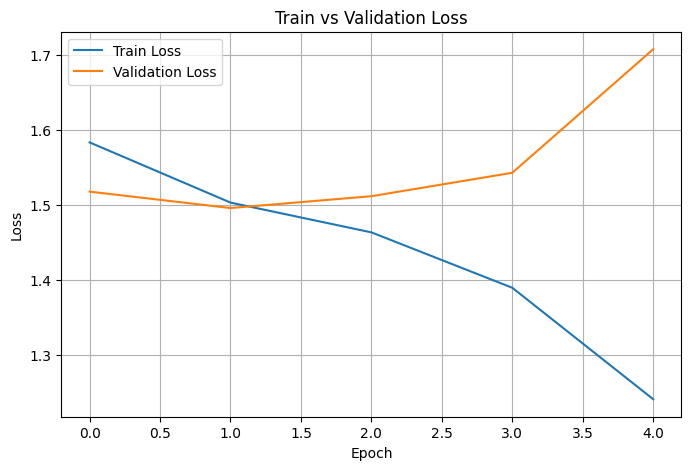

In [71]:
model3_fully_unfrozen = train_model_fully_unfrozen(MODEL_NAME3, train_loader, val_loader)

Evaluating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Resultados de la evaluación
Accuracy: 0.2962
F1 Macro: 0.2821
F1 Micro: 0.2962
F1 Weighted: 0.2978
Precision Macro: 0.2808
Precision Micro: 0.2962
Precision Weighted: 0.3008
Recall Macro: 0.2863
Recall Micro: 0.2962
Recall Weighted: 0.2962
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.35      0.35       191
           1       0.31      0.28      0.30       190
           2       0.31      0.29      0.30       171
           3       0.28      0.28      0.28       181
           4       0.16      0.23      0.19        57

    accuracy                           0.30       790
   macro avg       0.28      0.29      0.28       790
weighted avg       0.30      0.30      0.30       790



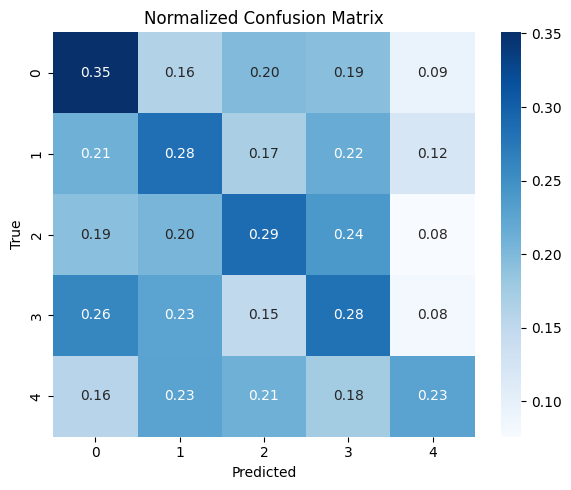

In [72]:
evaluate_model(model3_fully_unfrozen, test_loader)

Detectadas capas en: encoder.layer
Total capas encontradas: 12. Descongelando últimas 0.
Parametros entrenables: 126503425


Epoch 1/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 1, Loss: 1.5779


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.84it/s]


Validation Loss: 1.5181, Accuracy: 0.2443, F1 Score: 0.2362


Epoch 2/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 2, Loss: 1.5022


Validating: 100%|███████████████████████████████| 50/50 [00:13<00:00,  3.83it/s]


Validation Loss: 1.4956, Accuracy: 0.2696, F1 Score: 0.2600


Epoch 3/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 3, Loss: 1.4707


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


Validation Loss: 1.5141, Accuracy: 0.2772, F1 Score: 0.2700
EarlyStopping: 1/5


Epoch 4/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 4, Loss: 1.4068


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Validation Loss: 1.5635, Accuracy: 0.2797, F1 Score: 0.2691
EarlyStopping: 2/5


Epoch 5/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 5, Loss: 1.2810


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.6805, Accuracy: 0.2646, F1 Score: 0.2555
EarlyStopping: 3/5


Epoch 6/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 6, Loss: 1.0899


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 1.9173, Accuracy: 0.2797, F1 Score: 0.2661
EarlyStopping: 4/5


Epoch 7/10: 100%|█████████████████████████████| 231/231 [02:41<00:00,  1.43it/s]


Epoch 7, Loss: 0.9103


Validating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.85it/s]


Validation Loss: 2.1493, Accuracy: 0.2759, F1 Score: 0.2664
EarlyStopping: 5/5
Deteniendo entrenamiento por Early Stopping.


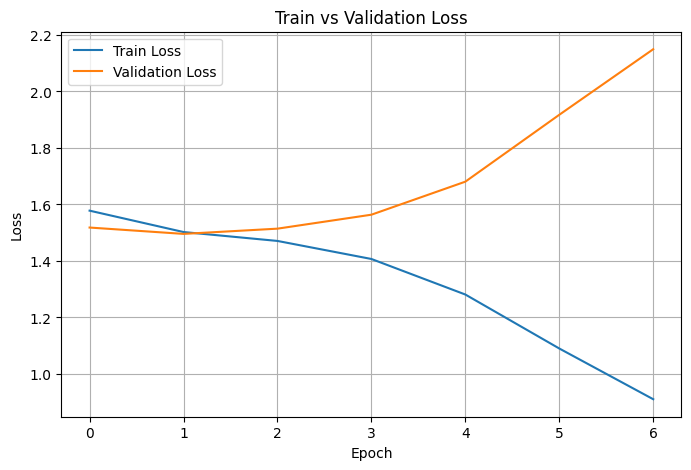

In [73]:
model3_fully_unfrozen = train_model_fully_unfrozen(MODEL_NAME3, train_loader, val_loader, patience=5)

Evaluating: 100%|███████████████████████████████| 50/50 [00:12<00:00,  3.89it/s]


Resultados de la evaluación
Accuracy: 0.2861
F1 Macro: 0.2723
F1 Micro: 0.2861
F1 Weighted: 0.2878
Precision Macro: 0.2714
Precision Micro: 0.2861
Precision Weighted: 0.2905
Recall Macro: 0.2752
Recall Micro: 0.2861
Recall Weighted: 0.2861
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.32      0.33       191
           1       0.30      0.29      0.30       190
           2       0.31      0.28      0.29       171
           3       0.26      0.27      0.27       181
           4       0.15      0.21      0.18        57

    accuracy                           0.29       790
   macro avg       0.27      0.28      0.27       790
weighted avg       0.29      0.29      0.29       790



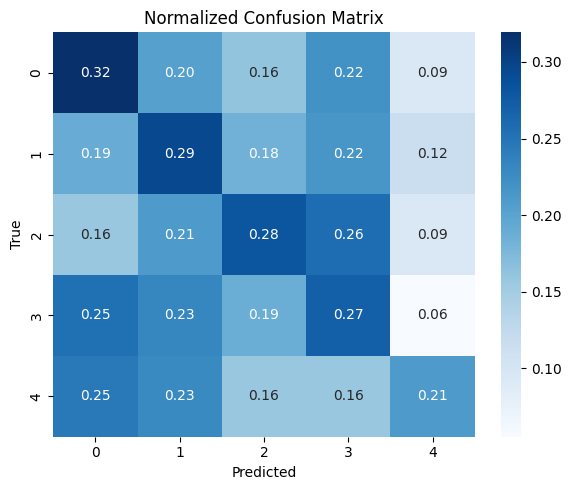

In [74]:
evaluate_model(model3_fully_unfrozen, test_loader)

A pesar de los esfuerzos por mitigar el sobreajuste, los modelos tienden a sobreajustarse rápidamente a los datos de entrenamiento. Sin embargo, se observa una mejora significativa en el rendimiento en comparación con las estrategias anteriores. El modelo basado en BERT alcanza un accuracy de 0.31 con 10 epocas de entrenamiento. Este resultado indica principalemnte que la tarea de resolver un Multiple Choice QA en español no es sencilla usando únicamente encoders preentrenados, pues es más un trabajo de generación de texto en el contexto requerido. Por esta razón, se ralizan experimentos adicionales usando decoders.